##**Analiza Danych Dźwiękowych z Użyciem Sieci Konwolucyjnych (CNN) i Biblioteki Librosa**



**Cel Instrukcji**


Celem instrukcji jest zapoznanie z analizą oraz wizualizacją danych dźwiękowych za pomocą biblioteki librosa oraz zastosowaniem sieci konwolucyjnych (CNN) do klasyfikacji stanów technicznych silnika na podstawie nagranych dźwięków jego pracy.

**Sieci Konwolucyjne (CNN)**


Sieci konwolucyjne to kluczowa technologia w dziedzinie głębokiego uczenia, wykorzystywana szczególnie w przetwarzaniu obrazów i dźwięku. Wyróżniają się one zdolnością do efektywnego wykrywania lokalnych wzorców i hierarchicznych cech w danych. Struktura CNN obejmuje warstwy konwolucyjne, które filtrują dane wejściowe, wykrywając charakterystyczne cechy, oraz warstwy łączące (pooling), które redukują wymiarowość danych, utrzymując najważniejsze informacje.



**Biblioteka Librosa**


Librosa jest zaawansowaną biblioteką do analizy audio w Pythonie. Umożliwia wczytywanie, analizę i wizualizację danych dźwiękowych. Dzięki niej, można łatwo ekstrahować różnorodne cechy audio, takie jak MFCC, spektrogramy, chromatogramy, czy spectral centroids. Librosa jest szczególnie przydatna w analizie muzycznej, przetwarzaniu mowy oraz w innych zastosowaniach związanych z dźwiękiem.

**Opis Danych i Cel Analizy**

Dane, na których pracujemy, składają się z nagrań dźwiękowych czterech różnych stanów silnika:

**Normalny ( normal )** - Nagranie dźwiękowe silnika pracującego w normalnych warunkach.

**Wewnętrzny ( inner )** - Nagranie dźwiękowe silnika z uszkodzeniem wewnętrznym.

**Wałek ( roller )** - Nagranie dźwiękowe silnika z uszkodzeniem w wałku.

**Zewnętrzny ( outer )** - Nagranie dźwiękowe silnika z uszkodzeniem zewnętrznym.


Celem analizy jest wykorzystanie tych nagrań do zrozumienia, jak różne defekty wpływają na dźwięk emitowany przez silnik. Analizując te różnice, można opracować metody predykcyjnego utrzymania maszyn i wykrywania wczesnych oznak awarii.

##**EDA i Wstępna Wizualizacja Danych Dźwiękowych**

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
import IPython.display as ipd

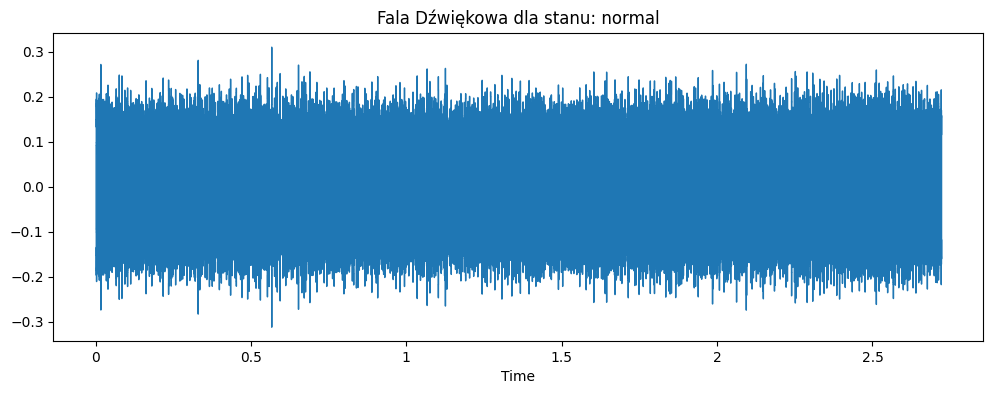

Odtwarzanie: normal


In [2]:
# Wczytanie danych z pliku .mat
data_path = 'dataset.mat'  # Scieżka do pliku w Google Colab
data = sio.loadmat(data_path)

# Ustawienie ziarna dla powtarzalności wyników
np.random.seed(42)
tf.random.set_seed(42)

# Przykładowe wczytanie i wizualizacja dla stanu "normalny"
key = 'normal'
audio_data = data[key].ravel()
sampling_rate = 44100  # Zdefiniowana częstotliwość próbkowania

# Wizualizacja fali dźwiękowej
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_data, sr=sampling_rate)
plt.title(f'Fala Dźwiękowa dla stanu: {key}')
plt.show()

# Odtwarzanie dźwięku
print(f'Odtwarzanie: {key}')
ipd.display(ipd.Audio(audio_data, rate=sampling_rate))

Zadanie dla studentów:

Przeprowadź analogiczną analizę dla pozostałych stanów silnika: wewnętrzny, wałek, zewnętrzny. Porównaj wizualizacje fal dźwiękowych oraz odsłuchaj nagrań.

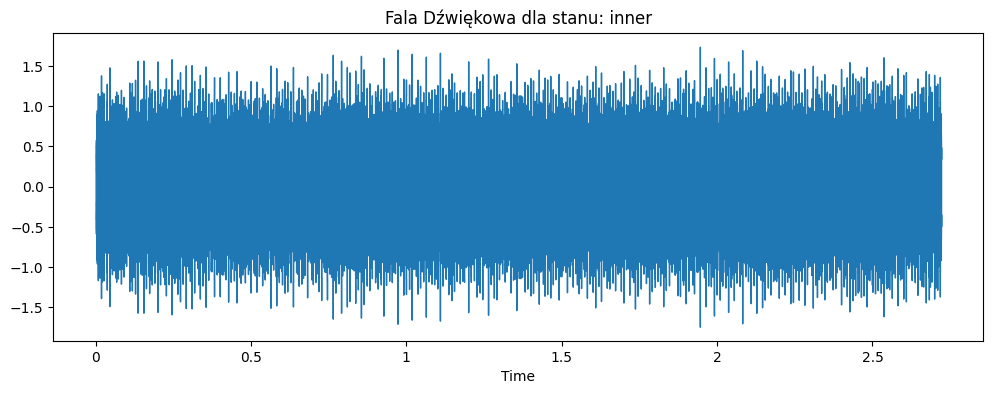

Odtwarzanie: inner


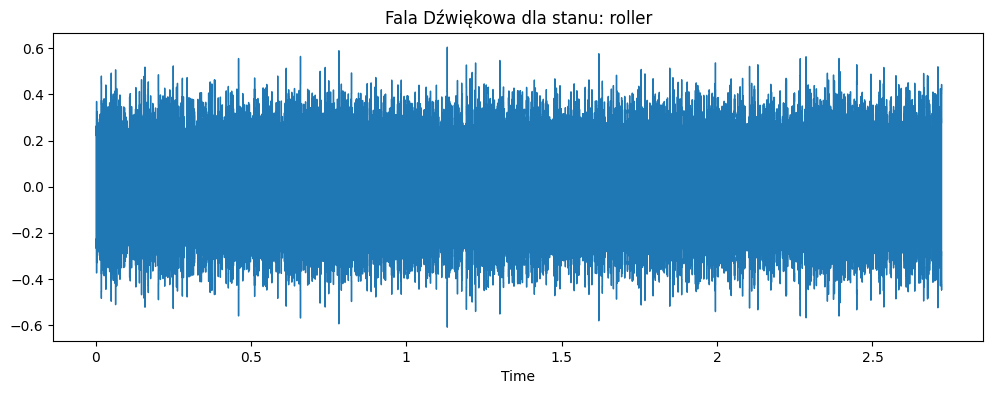

Odtwarzanie: roller


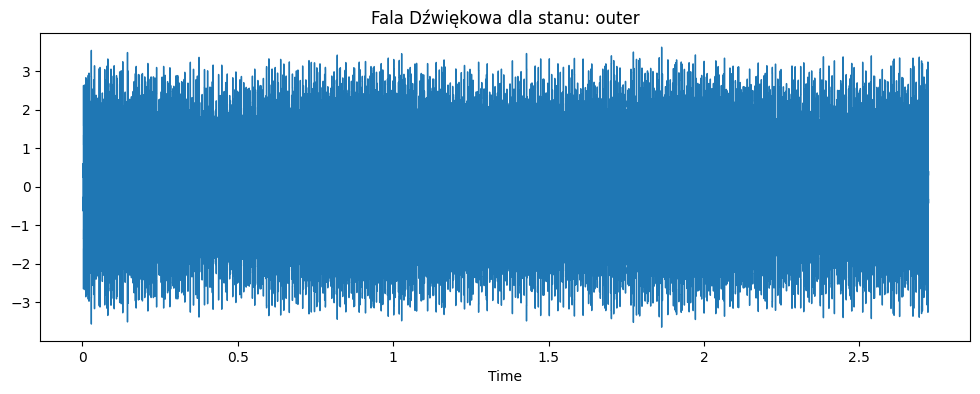

Odtwarzanie: outer


In [3]:
# Rozwiązanie

# Kod do wyświetlenia pozostałych stanów
for key in ['inner', 'roller', 'outer']:
    audio_data = data[key].ravel()

    # Wizualizacja fali dźwiękowej
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio_data, sr=sampling_rate)
    plt.title(f'Fala Dźwiękowa dla stanu: {key}')
    plt.show()

    # Odtwarzanie dźwięku
    print(f'Odtwarzanie: {key}')
    ipd.display(ipd.Audio(audio_data, rate=sampling_rate))

Zadania dla Studentów:


Porównaj fale dźwiękowe dla różnych stanów silnika (normalny, wewnętrzny, wałek, zewnętrzny). Jakie różnice zauważasz w ich formach?


Odsłuchaj każde nagranie. Czy potrafisz zidentyfikować różnice w dźwięku między poszczególnymi stanami silnika?


Zmodyfikuj częstotliwość próbkowania (na przykład na 4000 Hz) dla jednego z plików i porównaj, jak wpływa to na jakość dźwięku oraz jego falę dźwiękową.


Rozwiązania:


##**Przekształcenie Danych Dźwiękowych na Spektrogramy i Budowanie Sieci CNN**

Celem tego etapu jest zastosowanie przetworzonych danych dźwiękowych do stworzenia i wytrenowania modelu sieci konwolucyjnej (CNN), który będzie zdolny do klasyfikacji różnych stanów silnika. Następnie ocenimy wydajność modelu przy użyciu krzywych uczenia i walidacyjnych, a także różnych metryk klasyfikacyjnych.

**Wizualizacja Spektrogramu**


In [21]:
# Funkcja do tworzenia spektrogramu
def create_spectrogram(audio_data):
    stft = librosa.stft(audio_data)
    stft_db = librosa.amplitude_to_db(abs(stft))
    return stft_db

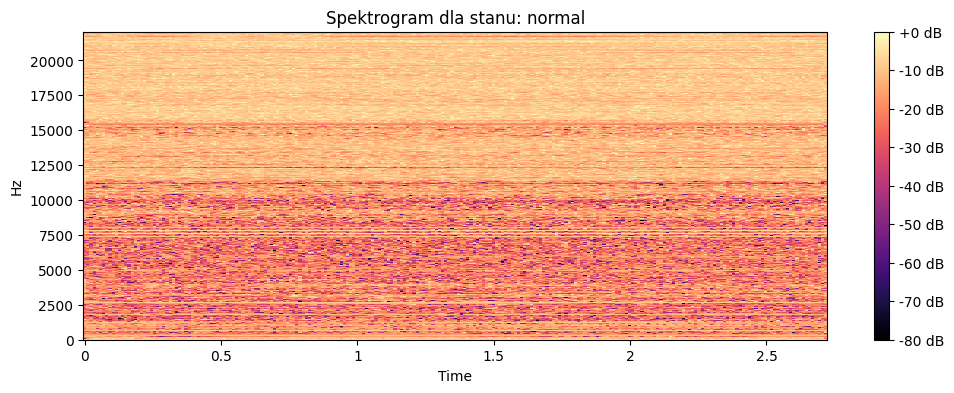

In [5]:
# Przykładowa wizualizacja spektrogramu dla stanu "normalny"
key = 'normal'
audio_data = data[key].ravel()
spectrogram = create_spectrogram(audio_data)

plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=44100, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spektrogram dla stanu: {key}')
plt.show()

Zadania dla Studentów:

Zwizualizuj spektrogramy dla pozostałych stanów silnika: wewnętrzny, wałek, zewnętrzny.

Rozwiązanie Zadań:


**Sieci CNN (Convolutional Neural Networks)**

Co to jest CNN?

Sieci konwolucyjne (CNN, od ang. Convolutional Neural Networks) to specjalny rodzaj sieci neuronowych, które są szeroko stosowane w przetwarzaniu obrazów, analizie wideo, i rozpoznawaniu mowy. Charakterystyczną cechą CNN jest wykorzystanie operacji konwolucji w co najmniej jednej z ich warstw. Konwolucja to matematyczna operacja wykorzystywana do wyodrębniania cech z danych wejściowych.

Zastosowania Praktyczne

CNN są używane w wielu dziedzinach, od rozpoznawania obrazów (np. w samochodach autonomicznych, do identyfikacji pieszych), przez medycynę (analiza obrazów medycznych), po bezpieczeństwo (systemy monitoringu wizyjnego).

Jak Działają CNN?

Sieci te składają się z trzech głównych typów warstw: konwolucyjnych, poolingowych (łączących) i w pełni połączonych. Warstwy konwolucyjne stosują filtry do wyodrębniania istotnych cech z danych wejściowych. Warstwy poolingowe redukują wymiarowość danych, zachowując istotne informacje. Na końcu znajdują się w pełni połączone warstwy, które klasyfikują dane na podstawie wyodrębnionych cech.

Różnice względem Zwykłych Sieci Neuronowych

Główna różnica między CNN a standardowymi sieciami neuronowymi (Fully Connected Networks) polega na sposobie przetwarzania danych. CNN są zaprojektowane do pracy z danymi mającymi przestrzenną lub czasową strukturę, dzięki czemu są bardziej efektywne w przetwarzaniu obrazów, dźwięków czy sekwencji czasowych.

In [24]:
# Parametry podziału nagrań
segment_length = 8000  # Długość segmentu w próbkach
hop_length = 1000 # Ilość próbek przesunięcia do następnego segmentu

# Przygotowanie danych do modelu CNN
X = []
y = []

for i, key in enumerate(['normal', 'inner', 'roller', 'outer']):
    audio_data = data[key].ravel()
    # Podział na segmenty
    for j in range(0, len(audio_data) - segment_length + 1, hop_length):
        segment = audio_data[j:j + segment_length]
        spectrogram = create_spectrogram(segment)
        # f = plt.figure()
        # plt.imshow(spectrogram)
        spectrogram = np.pad(spectrogram, ((0, max(0, 128 - spectrogram.shape[0])), (0, max(0, 128 - spectrogram.shape[1]))), mode='constant', constant_values=0)
        
        
        X.append(spectrogram)
        y.append(i)

X = np.array(X)[..., np.newaxis]
y = np.array(y)

# Normalizacja danych
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# Podział danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Zamiana etykiet na format one-hot
num_classes = 4
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

In [25]:
# Budowanie modelu CNN z dodatkowymi warstwami i Dropout
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Trening z dłuższą liczbą epok
history = model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), epochs=12, batch_size=64)

Epoch 1/12
6/6 [==============================] - 12s 2s/step - loss: 40.9481 - accuracy: 0.2604 - val_loss: 1.3819 - val_accuracy: 0.2967
Epoch 2/12
6/6 [==============================] - 10s 2s/step - loss: 1.3913 - accuracy: 0.2327 - val_loss: 1.3864 - val_accuracy: 0.1648
Epoch 3/12
6/6 [==============================] - 10s 2s/step - loss: 1.3915 - accuracy: 0.2493 - val_loss: 1.3870 - val_accuracy: 0.1648
Epoch 4/12
6/6 [==============================] - 10s 2s/step - loss: 1.3706 - accuracy: 0.3269 - val_loss: 1.3879 - val_accuracy: 0.1648
Epoch 5/12
6/6 [==============================] - 10s 2s/step - loss: 1.3486 - accuracy: 0.3186 - val_loss: 1.3714 - val_accuracy: 0.1648
Epoch 6/12
6/6 [==============================] - 10s 2s/step - loss: 1.2924 - accuracy: 0.4100 - val_loss: 1.3434 - val_accuracy: 0.1648
Epoch 7/12
6/6 [==============================] - 11s 2s/step - loss: 1.1476 - accuracy: 0.4681 - val_loss: 1.2476 - val_accuracy: 0.6923
Epoch 8/12
6/6 [=================

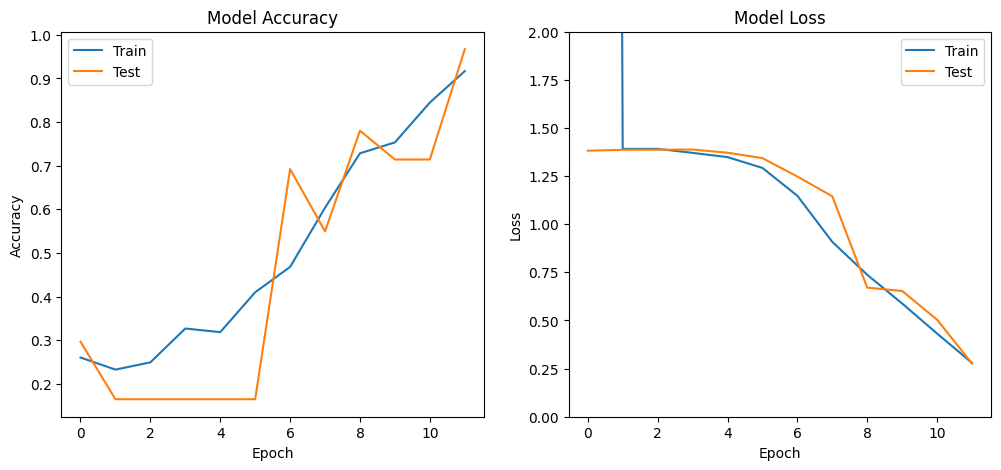

In [31]:
# Wizualizacja wyników
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.ylim((0,2))
plt.xlabel('Epoch')
plt.legend()

plt.show()

3/3 [==============================] - 1s 227ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.83      1.00      0.91        15
           2       1.00      1.00      1.00        23
           3       1.00      0.88      0.94        26

    accuracy                           0.97        91
   macro avg       0.96      0.97      0.96        91
weighted avg       0.97      0.97      0.97        91



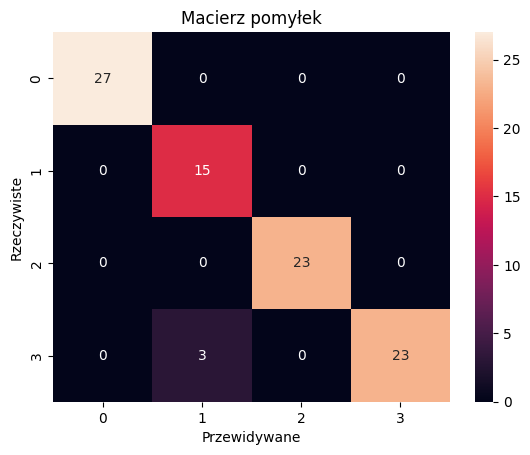

In [28]:
# Raport klasyfikacji
y_pred = model.predict(X_test)
predicted_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_classes))

# Macierz pomyłek
cm = confusion_matrix(y_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Macierz pomyłek')
plt.ylabel('Rzeczywiste')
plt.xlabel('Przewidywane')
plt.show()

Zadania dla Studentów:

Zmodyfikuj parametry modelu CNN (np. liczbę warstw, wielkość kerneli) i zobacz, jak wpłynie to na wyniki.

Zmień sposób podziału danych na zestawy treningowe i testowe. Jak wpływa to na wyniki modelu?

Porównaj wydajność modelu przy różnych liczbie epok trenowania.

W jaki sposób zmiana parametrów podziału nagrań wpływa na naszą sieć, dlaczego stosujemy takie rozwiązanie?

Rozwiązanie Zadań:


##**Przekształcenie Danych Dźwiękowych na MelSpektrogramy i Budowanie Sieci CNN**

**Co to jest Mel Spektrogram?**


Mel spektrogram to reprezentacja częstotliwości sygnału dźwiękowego z czasem, z wykorzystaniem skali melowej. Skala melowa jest skalą percepcji wysokości dźwięku, która próbuje bardziej odwzorować, jak ludzkie ucho odbiera dźwięk, w przeciwieństwie do liniowej skali częstotliwości. Spektrogramy melowe są często stosowane w przetwarzaniu sygnałów dźwiękowych, szczególnie w rozpoznawaniu mowy i muzyki, ponieważ lepiej odzwierciedlają ludzką percepcję dźwięku.

Zmienimy funkcję tworzenia spektrogramu, aby generować mel spektrogramy, a następnie użyjemy ich do budowy i trenowania modelu CNN.

In [ ]:
#Funkcja do tworzenia mel sektrogramu
def create_mel_spectrogram(audio_data, sr=44100, n_fft=2048, hop_length=1024, n_mels=128):
    S = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

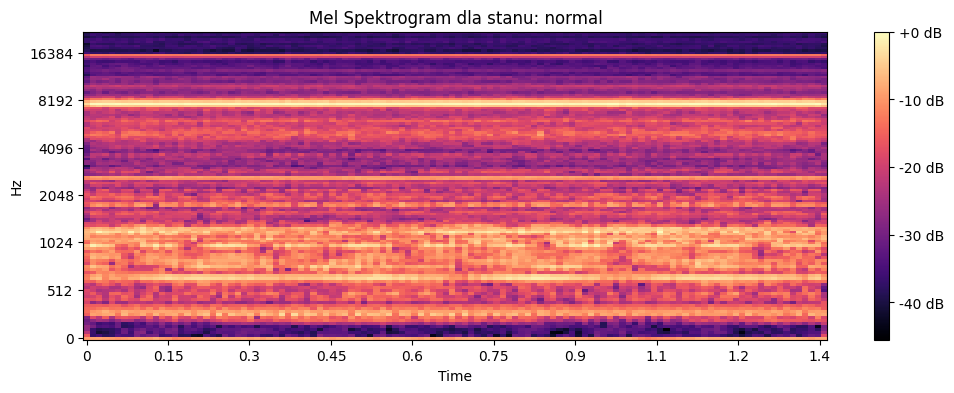

In [ ]:
# Przykładowa wizualizacja mel spektrogramu dla stanu "normalny"
key = 'normal'
audio_data = data[key].ravel()
mel_spectrogram = create_mel_spectrogram(audio_data)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_spectrogram, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spektrogram dla stanu: {key}')
plt.show()

Zadania dla Studentów:

Zwizualizuj mel spektrogramy dla pozostałych stanów silnika: wewnętrzny, wałek, zewnętrzny.

Rozwiązanie Zadań:


In [ ]:
# Parametry podziału nagrań
segment_length_mel = 8000  # Długość segmentu w próbkach
hop_length_mel = 4000      # Ilość próbek przesunięcia do następnego segmentu

# Przygotowanie danych do modelu CNN z użyciem mel spektrogramów
X_mel = []
y_mel = []

for i, key in enumerate(['normal', 'inner', 'roller', 'outer']):
    audio_data = data[key].ravel()
    # Podział na segmenty
    for j in range(0, len(audio_data) - segment_length_mel + 1, hop_length_mel):
        segment = audio_data[j:j + segment_length_mel]
        mel_spectrogram = create_mel_spectrogram(segment)
        mel_spectrogram = np.pad(mel_spectrogram, ((0, max(0, 128 - mel_spectrogram.shape[0])), (0, max(0, 128 - mel_spectrogram.shape[1]))), mode='constant', constant_values=0)
        X_mel.append(mel_spectrogram)
        y_mel.append(i)

X_mel = np.array(X_mel)[..., np.newaxis]
y_mel = np.array(y_mel)

# Normalizacja danych
X_mel = (X_mel - np.min(X_mel)) / (np.max(X_mel) - np.min(X_mel))

# Podział danych na treningowe i testowe dla mel spektrogramów
X_train_mel, X_test_mel, y_train_mel, y_test_mel = train_test_split(X_mel, y_mel, test_size=0.2, random_state=42)

# Zamiana etykiet na format one-hot dla mel spektrogramów
y_train_mel_one_hot = to_categorical(y_train_mel, num_classes)
y_test_mel_one_hot = to_categorical(y_test_mel, num_classes)


In [ ]:
# Budowanie modelu CNN dla mel spektrogramów
model_mel = Sequential()

model_mel.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(X_train_mel.shape[1], X_train_mel.shape[2], 1)))
model_mel.add(MaxPooling2D(pool_size=(2, 2)))
model_mel.add(Dropout(0.25))

model_mel.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model_mel.add(MaxPooling2D(pool_size=(2, 2)))
model_mel.add(Dropout(0.25))

model_mel.add(Flatten())
model_mel.add(Dense(64, activation='relu'))
model_mel.add(Dropout(0.5))
model_mel.add(Dense(num_classes, activation='softmax'))

model_mel.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Trenowanie modelu na mel spektrogramach
history_mel = model_mel.fit(X_train_mel, y_train_mel_one_hot, validation_data=(X_test_mel, y_test_mel_one_hot), epochs=12, batch_size=64)

Epoch 1/12
2/2 [==============================] - 2s 583ms/step - loss: 7.9930 - accuracy: 0.2500 - val_loss: 2.5067 - val_accuracy: 0.2917
Epoch 2/12
2/2 [==============================] - 1s 372ms/step - loss: 6.5804 - accuracy: 0.2283 - val_loss: 1.3850 - val_accuracy: 0.2500
Epoch 3/12
2/2 [==============================] - 2s 672ms/step - loss: 1.3943 - accuracy: 0.3370 - val_loss: 1.3858 - val_accuracy: 0.2917
Epoch 4/12
2/2 [==============================] - 2s 669ms/step - loss: 1.3874 - accuracy: 0.2174 - val_loss: 1.3860 - val_accuracy: 0.2917
Epoch 5/12
2/2 [==============================] - 2s 646ms/step - loss: 1.3867 - accuracy: 0.2717 - val_loss: 1.3861 - val_accuracy: 0.2917
Epoch 6/12
2/2 [==============================] - 1s 371ms/step - loss: 1.3857 - accuracy: 0.2500 - val_loss: 1.3862 - val_accuracy: 0.2917
Epoch 7/12
2/2 [==============================] - 1s 443ms/step - loss: 1.3858 - accuracy: 0.2826 - val_loss: 1.3864 - val_accuracy: 0.2917
Epoch 8/12
2/2 [====

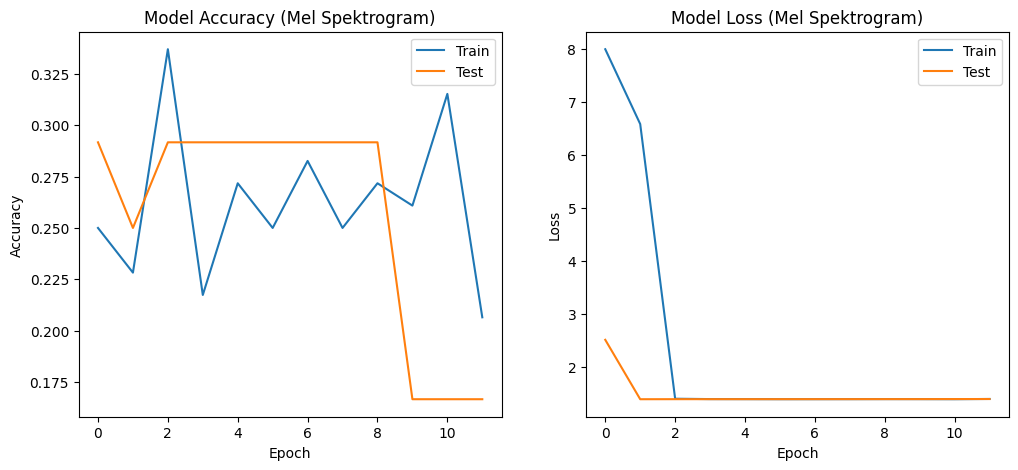

In [ ]:
# Wizualizacja wyników
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mel.history['accuracy'], label='Train')
plt.plot(history_mel.history['val_accuracy'], label='Test')
plt.title('Model Accuracy (Mel Spektrogram)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mel.history['loss'], label='Train')
plt.plot(history_mel.history['val_loss'], label='Test')
plt.title('Model Loss (Mel Spektrogram)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

1/1 [==============================] - 0s 147ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         7
           2       0.17      1.00      0.29         4
           3       0.00      0.00      0.00         6

    accuracy                           0.17        24
   macro avg       0.04      0.25      0.07        24
weighted avg       0.03      0.17      0.05        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


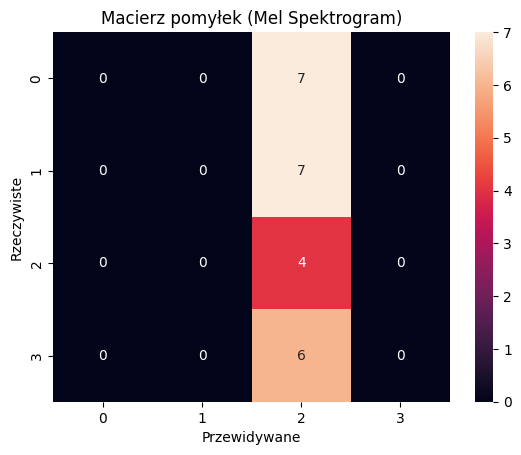

In [ ]:
# Raport klasyfikacji dla mel spektrogramów
y_pred_mel = model_mel.predict(X_test_mel)
predicted_classes_mel = np.argmax(y_pred_mel, axis=1)
print(classification_report(y_test_mel, predicted_classes_mel))

# Macierz pomyłek dla mel spektrogramów
cm_mel = confusion_matrix(y_test_mel, predicted_classes_mel)
sns.heatmap(cm_mel, annot=True, fmt='d')
plt.title('Macierz pomyłek (Mel Spektrogram)')
plt.ylabel('Rzeczywiste')
plt.xlabel('Przewidywane')
plt.show()

Zadania dla Studentów:


Jakie są główne różnice między zwykłym spektrogramem a mel spektrogramem, i dlaczego mel spektrogram może być preferowany w niektórych zastosowaniach przetwarzania dźwięku?

Jak wpływa liczba filtrów w warstwach konwolucyjnych sieci CNN na jej zdolność do nauki z danych? Porównaj wyniki modelu z różnymi konfiguracjami liczby filtrów.

Wyjaśnij, jakie funkcje pełnią warstwy takie jak MaxPooling2D i Dropout w architekturze CNN. Dlaczego są one ważne?

Przeanalizuj wykresy dokładności i straty modelu. Co można wywnioskować o procesie uczenia się na podstawie tych wykresów?

Rozwiązania:



##**Podsumowanie wyników**

Zadania dla studentów:

Jakie czynniki należy wziąć pod uwagę przy wyborze między spektrogramami a mel spektrogramami jako danymi wejściowymi do modelu CNN w kontekście analizy dźwięku?

Jak zmiana liczby warstw konwolucyjnych w CNN wpływa na zdolność modelu do uczenia się złożonych cech?

Dlaczego klasyfikacja za pomocą sieci CNN dla obu przypadków przyniosła tak słabe rezultaty?

Rozwiązanie:


